In [1]:
import numpy as np
import pandas as pd
import matplotlib . pyplot as plt # plots
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE
from sklearn.metrics import make_scorer

## Train and Test sets

In [2]:
ml_data = pd.read_csv('ml_data.csv')

In [3]:
ml_data.head()

,Unnamed: 0,GEOID,geometry,NAME,% White,% Black,Median Income,Median Age,% High School,Median Home Value,tests,group,group_num,avg_d_mbps_wt
0,0,54001,"POLYGON ((1099938.640928884 4367132.49619047, ...",Barbour,95.977286,1.237298,39580.0,41.7,46.050420,104800,587.0,0 to 25 Mbps,1.0,16.296029
1,1,35055,POLYGON ((-1203494.477007749 4178635.812199121...,Taos,85.225614,0.462175,36758.0,48.2,26.281730,236600,1176.0,0 to 25 Mbps,1.0,19.725375
2,2,21105,"POLYGON ((310238.4882698005 4056769.802732044,...",Hickman,87.193520,9.435201,40463.0,46.6,39.397627,79100,192.0,0 to 25 Mbps,1.0,20.418672
3,3,28111,"POLYGON ((308644.6010505108 3479411.070403925,...",Perry,78.774526,19.687396,39007.0,40.9,40.131739,83700,214.0,0 to 25 Mbps,1.0,9.450393
4,4,20019,POLYGON ((-346338.9773293015 4159970.328556712...,Chautauqua,87.139887,0.594001,38690.0,48.8,35.568275,62500,107.0,0 to 25 Mbps,1.0,15.561673


In [4]:
ml_data.describe()

,Unnamed: 0,GEOID,% White,% Black,Median Income,Median Age,% High School,Median Home Value,tests,group_num,avg_d_mbps_wt
count,3108.000000,3108.000000,3108.000000,3108.000000,3107.000000,3108.000000,3108.000000,3.108000e+03,3.011000e+03,3011.000000,3011.000000
mean,1553.500000,30671.834299,83.443092,9.144295,51399.036048,41.323938,34.288408,-6.843815e+04,1.104743e+04,3.014613,81.007389
std,897.346644,14983.766520,16.330278,14.587343,13597.976997,5.385473,7.187729,1.196122e+07,4.550243e+04,1.065833,42.703892
min,0.000000,1001.000000,4.973840,0.000000,20188.000000,21.700000,5.470321,-6.666667e+08,5.200000e+01,1.000000,5.935230
25%,776.750000,19044.500000,77.265387,0.677874,42420.000000,38.100000,29.827527,9.350000e+04,6.315000e+02,2.000000,45.774190
50%,1553.500000,29212.000000,89.822617,2.326518,49772.000000,41.200000,34.569260,1.219000e+05,1.796000e+03,3.000000,78.774097
75%,2330.250000,46007.500000,95.099937,10.311633,57340.500000,44.425000,39.279057,1.676000e+05,5.771500e+03,4.000000,113.467451
max,3107.000000,56045.000000,100.000000,87.412281,136268.000000,67.000000,55.619930,1.056500e+06,1.598873e+06,6.000000,218.526125


In [5]:
ml_data.loc[ml_data['Median Home Value'] < 0, 'Median Home Value'] = ml_data['Median Home Value'].median()

In [6]:
train_data = ml_data[ml_data.group_num.notna()]
test_data = ml_data[ml_data.group_num.isna()]

In [7]:
median_income = train_data['Median Income'].median()
train_data = train_data.fillna(value=median_income)

In [8]:
test_data.count()

Unnamed: 0           97
GEOID                97
geometry             97
NAME                 97
% White              97
% Black              97
Median Income        97
Median Age           97
% High School        97
Median Home Value    97
tests                 0
group                 0
group_num             0
avg_d_mbps_wt         0
dtype: int64

In [9]:
features = ['% White', '% Black','Median Income', 'Median Age', '% High School', 'Median Home Value']
label = ['group_num']
x_train = train_data.loc[:,features]
y_train = train_data.loc[:,label]
x_test = test_data.loc[:,features]
y_test = test_data.loc[:,label]
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [10]:
x_train.head()

,% White,% Black,Median Income,Median Age,% High School,Median Home Value
0,95.977286,1.237298,39580.0,41.7,46.050420,104800.0
1,85.225614,0.462175,36758.0,48.2,26.281730,236600.0
2,87.193520,9.435201,40463.0,46.6,39.397627,79100.0
3,78.774526,19.687396,39007.0,40.9,40.131739,83700.0
4,87.139887,0.594001,38690.0,48.8,35.568275,62500.0


In [11]:
# creating a KFold object with 5 splits 
folds = KFold(n_splits = 10, shuffle = True, random_state = 100)

# specify range of hyperparameters
hyper_params = [{'n_features_to_select': list(range(2, 7))}]

#Custom Function for accuracy
def custom_acc(y_train, y_pred):
    y_pred = y_pred.round()
    diff = np.abs(y_train - y_pred).sum()
    return diff/len(y_train)

acc = make_scorer(custom_acc)

## Lineal Model

In [12]:
# Lineal Model
lm = LinearRegression(normalize=True)
lm.fit(x_train, y_train)
rfe = RFE(lm)  

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= acc, 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
results = model_cv.fit(x_train, y_train)
ls_results = pd.DataFrame(results.cv_results_)

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished


In [13]:
ls_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_n_features_to_select', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'split5_test_score', 'split6_test_score',
       'split7_test_score', 'split8_test_score', 'split9_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score',
       'split0_train_score', 'split1_train_score', 'split2_train_score',
       'split3_train_score', 'split4_train_score', 'split5_train_score',
       'split6_train_score', 'split7_train_score', 'split8_train_score',
       'split9_train_score', 'mean_train_score', 'std_train_score'],
      dtype='object')

In [14]:
ls_results.filter(['param_n_features_to_select','mean_test_score', 'rank_test_score', 'mean_train_score'])

,param_n_features_to_select,mean_test_score,rank_test_score,mean_train_score
0,2,0.750569,2,0.748994
1,3,0.749570,3,0.746300
2,4,0.750897,1,0.746116
3,5,0.698108,4,0.697849
4,6,0.696768,5,0.692719


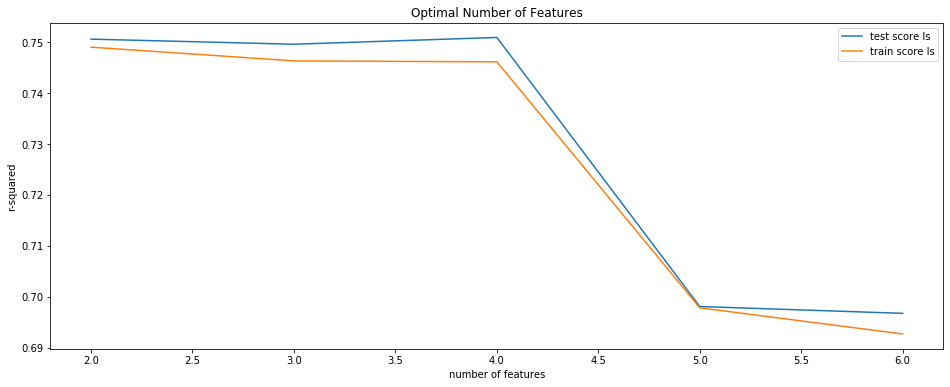

In [15]:
plt.figure(figsize=(16,6))

plt.plot(ls_results["param_n_features_to_select"], ls_results["mean_test_score"])
plt.plot(ls_results["param_n_features_to_select"], ls_results["mean_train_score"])
plt.xlabel('number of features')
#plt.ylim(0,1)
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score ls', 'train score ls'], loc='upper right')

In [16]:
# final best model least squares
n_features_optimal = 4

lm = LinearRegression()
lm.fit(x_train, y_train)


rfe = RFE(lm, n_features_to_select=n_features_optimal)             
rfe = rfe.fit(x_train, y_train)
print(rfe.support_)
print(rfe.ranking_)

# predict prices of X_test
y_pred_ls = (lm.predict(x_test)).round()

[ True  True False  True  True False]
[1 1 2 1 1 3]


In [18]:
y_pred_ls

array([2., 2., 3., 3., 3., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 2.,
       3., 2., 2., 3., 3., 3., 3., 2., 2., 2., 2., 2., 3., 3., 1., 2., 2.,
       3., 3., 2., 2., 2., 3., 3., 2., 2., 2., 2., 2., 2., 3., 3., 3., 3.,
       3., 2., 3., 3., 3., 2., 3., 3., 3., 3., 2., 3., 2., 2., 3., 2., 3.,
       2., 2., 2., 3., 2., 2., 2., 3., 3., 3., 2., 3., 2., 2., 2., 2., 3.,
       2., 3., 3., 2., 4., 2., 2., 3., 3., 2., 3., 2.])

## Ridge Model
Penalization parameters = 10^1, 10^5, 10^10

In [19]:
#---------RIDGE----------------

# specify range of hyperparameters
alpha = [10**1, 10**5, 10**10]

df_rd = pd.DataFrame(columns = ['alpha', 'features','mean_test_score', 'rank_test_score', 'mean_train_score']) 

for i in alpha:
    # specify model
    rd = Ridge(alpha=i, normalize=False)
    rd.fit(x_train, y_train)
    rfe_rd = RFE(rd)  

    # set up GridSearchCV()
    model_rd = GridSearchCV(estimator = rfe_rd, 
                            param_grid = hyper_params, 
                            scoring= acc, 
                            cv = folds, 
                            verbose = 1,
                            return_train_score=True)      

    # fit the model
    results_rd = model_rd.fit(x_train, y_train)
    rd_results = pd.DataFrame(results_rd.cv_results_)
    for index, row in rd_results.iterrows():
        df_rd = df_rd.append({'alpha' : i, 'features' : rd_results.loc[index, 'param_n_features_to_select'], 
                              'mean_test_score' : rd_results.loc[index, 'mean_test_score'], 
                              'rank_test_score':rd_results.loc[index, 'rank_test_score'],
                             'mean_train_score':rd_results.loc[index, 'mean_train_score']},  
                    ignore_index = True)

df_rd

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished


,alpha,features,mean_test_score,rank_test_score,mean_train_score
0,1.000000e+01,2.0,0.750569,1.0,0.749031
1,1.000000e+01,3.0,0.749570,3.0,0.746300
2,1.000000e+01,4.0,0.750564,2.0,0.746116
3,1.000000e+01,5.0,0.698108,4.0,0.697738
4,1.000000e+01,6.0,0.696768,5.0,0.692682
5,1.000000e+05,2.0,0.774149,2.0,0.774309
6,1.000000e+05,3.0,0.773485,3.0,0.771024
7,1.000000e+05,4.0,0.774480,1.0,0.771541
8,1.000000e+05,5.0,0.710066,5.0,0.709583
9,1.000000e+05,6.0,0.715702,4.0,0.716890


#### Best Ridge Model
- Features = 4
- Penalization = 10^5

In [20]:
# final model Ridge
n_features_optimal = 4

rd = Ridge(alpha=(10**5), normalize=False)
rd.fit(x_train, y_train)
rfe_rd = RFE(rd, n_features_to_select=n_features_optimal)  
          
rfe_rd = rfe_rd.fit(x_train, y_train)
print(rfe_rd.support_)
print(rfe_rd.ranking_)

# predict prices of X_test
y_pred_rd = (rd.predict(x_test)).round()

[ True  True False  True  True False]
[1 1 2 1 1 3]


In [21]:
y_pred_rd

array([2., 2., 3., 3., 3., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 2., 2., 3., 3., 2., 3., 3., 2., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 2., 3., 3., 3., 2., 3., 2., 3., 3., 3., 3., 2., 3., 3., 3., 3.,
       3., 3., 3., 3., 2., 2., 3., 3., 3., 4., 3., 3., 2., 2., 3., 2., 3.,
       2., 3., 3., 2., 3., 2., 3., 3., 3., 2., 3., 3.])

## Logistic Regression
Penalization Parameters = 0.01, 0.1, 1, 10, 100

In [22]:
#--------------------Logistic Regression-----------------------------
from sklearn.linear_model import LogisticRegression
# specify range of hyperparameters
C = [0.01, 0.1,1,10,100]

df_clf = pd.DataFrame(columns = ['C', 'features','mean_test_score', 'rank_test_score', 'mean_train_score']) 

# specify model
for i in C:
    clf = LogisticRegression(random_state=0, max_iter=1000, solver='lbfgs', C=i)
    clf.fit(x_train, y_train)
    rfe_clf = RFE(clf)  

    # set up GridSearchCV()
    model_clf = GridSearchCV(estimator = rfe_clf, 
                            param_grid = hyper_params, 
                            scoring= acc, 
                            cv = folds, 
                            verbose = 1,
                            return_train_score=True)      

    # fit the model
    results_clf = model_clf.fit(x_train, y_train)
    clf_results = pd.DataFrame(results_clf.cv_results_)
    for index, row in clf_results.iterrows():
        df_clf = df_clf.append({'C' : i, 'features' : clf_results.loc[index, 'param_n_features_to_select'], 
                              'mean_test_score' : clf_results.loc[index, 'mean_test_score'], 
                              'rank_test_score':clf_results.loc[index, 'rank_test_score'],
                             'mean_train_score':clf_results.loc[index, 'mean_train_score']},  
                    ignore_index = True)

df_clf

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\Maca\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Maca\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver opti

C:\Users\Maca\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Maca\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regre

C:\Users\Maca\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Maca\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regre

C:\Users\Maca\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Maca\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regre

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\Maca\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Maca\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver opti

C:\Users\Maca\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Maca\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regre

C:\Users\Maca\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Maca\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regre

C:\Users\Maca\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Maca\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regre

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\Maca\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Maca\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver opti

C:\Users\Maca\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Maca\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regre

C:\Users\Maca\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Maca\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regre

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\Maca\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Maca\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver opti

C:\Users\Maca\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Maca\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regre

C:\Users\Maca\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Maca\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regre

C:\Users\Maca\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Maca\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regre

Fitting 10 folds for each of 5 candidates, totalling 50 fits


C:\Users\Maca\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Maca\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regre

C:\Users\Maca\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Maca\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regre

C:\Users\Maca\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Maca\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regre

C:\Users\Maca\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Maca\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regre

,C,features,mean_test_score,rank_test_score,mean_train_score
0,0.01,2.0,0.726320,1.0,0.725045
1,0.01,3.0,0.719001,3.0,0.714786
2,0.01,4.0,0.720334,2.0,0.717185
3,0.01,5.0,0.704398,5.0,0.700137
4,0.01,6.0,0.706387,4.0,0.701539
5,0.10,2.0,0.734294,1.0,0.733163
6,0.10,3.0,0.719998,3.0,0.715118
7,0.10,4.0,0.721663,2.0,0.719030
8,0.10,5.0,0.703069,5.0,0.697185
9,0.10,6.0,0.704062,4.0,0.700432


In [23]:
df_clf

,C,features,mean_test_score,rank_test_score,mean_train_score
0,0.01,2.0,0.726320,1.0,0.725045
1,0.01,3.0,0.719001,3.0,0.714786
2,0.01,4.0,0.720334,2.0,0.717185
3,0.01,5.0,0.704398,5.0,0.700137
4,0.01,6.0,0.706387,4.0,0.701539
5,0.10,2.0,0.734294,1.0,0.733163
6,0.10,3.0,0.719998,3.0,0.715118
7,0.10,4.0,0.721663,2.0,0.719030
8,0.10,5.0,0.703069,5.0,0.697185
9,0.10,6.0,0.704062,4.0,0.700432


#### Best Logistic Model
- Features = 4
- Penalization = 1

In [24]:
# final model Logistic
n_features_optimal = 4

clf = LogisticRegression(random_state=0, max_iter=1000, solver='lbfgs', C=1)
clf.fit(x_train, y_train)
rfe_clf = RFE(clf, n_features_to_select=n_features_optimal)
          
rfe_clf = rfe_clf.fit(x_train, y_train)
print(rfe_clf.support_)
print(rfe_clf.ranking_)

# predict prices of X_test
y_pred_clf = (clf.predict(x_test)).round()

[ True  True False  True  True False]
[1 1 2 1 1 3]


C:\Users\Maca\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [25]:
y_pred_clf

array([3., 3., 3., 3., 3., 3., 2., 2., 3., 4., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 4., 3., 3., 3., 3., 3., 2., 3., 3., 3., 3., 3., 2., 3., 5.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 2., 3., 3., 3., 3., 3., 2., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 2., 3., 5., 4.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 4., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 4., 3., 3., 3., 3., 3., 3., 3.])

## SVM
Penalization Parameters = 0.5, 1, 10000

In [ ]:
#--------------------SVM-----------------------------

# specify range of hyperparameters
C = [0.5, 1, 10000]

df_svm = pd.DataFrame(columns = ['C', 'features','mean_test_score', 'rank_test_score', 'mean_train_score']) 

for i in C:
    # specify model
    svm = SVC(kernel='linear', C=i)
    svm.fit(x_train, y_train)
    rfe_svm = RFE(svm)  

    # set up GridSearchCV()
    model_svm = GridSearchCV(estimator = rfe_svm, 
                            param_grid = hyper_params, 
                            scoring= acc, 
                            cv = folds, 
                            verbose = 1,
                            return_train_score=True)      

    # fit the model
    results_svm = model_svm.fit(x_train, y_train)
    svm_results = pd.DataFrame(results_svm.cv_results_)
    for index, row in svm_results.iterrows():
        df_svm = df_svm.append({'C' : i, 'features' : svm_results.loc[index, 'param_n_features_to_select'], 
                              'mean_test_score' : svm_results.loc[index, 'mean_test_score'], 
                              'rank_test_score':svm_results.loc[index, 'rank_test_score'],
                             'mean_train_score':svm_results.loc[index, 'mean_train_score']},  
                    ignore_index = True)

df_svm

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


## Aggregate all the best models in one Dataset

In [26]:
data = {'Features':  [2, 3,4,5,6]}

df = pd.DataFrame(data)
df['ls_mean_test_score'] = ls_results['mean_test_score']

In [27]:
df_rd_max = df_rd.groupby('features').mean_test_score.agg(['max']).reset_index()
df['rd_mean_test_score'] = df_rd_max['max']

In [28]:
df_clf_max = df_clf.groupby('features').mean_test_score.agg(['max']).reset_index()
df['clf_mean_test_score'] = df_clf_max['max']

In [29]:
df

,Features,ls_mean_test_score,rd_mean_test_score,clf_mean_test_score
0,2,0.750569,0.774149,0.734294
1,3,0.749570,0.773485,0.720663
2,4,0.750897,0.774480,0.725651
3,5,0.698108,0.737624,0.705395
4,6,0.696768,0.737624,0.706387


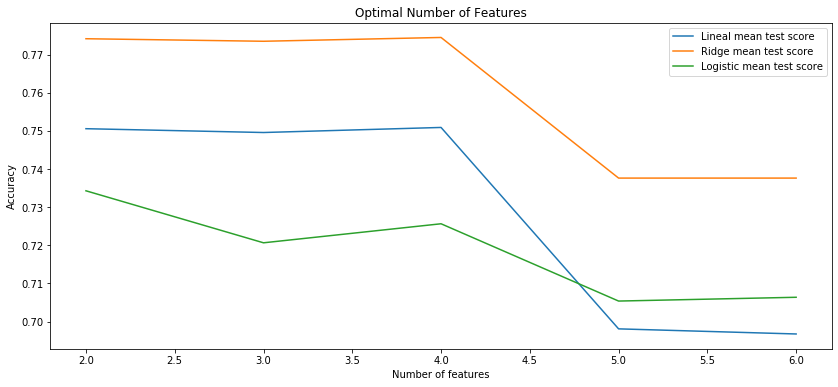

In [30]:
plt.figure(figsize=(14,6))

plt.plot(df["Features"], df["ls_mean_test_score"])
plt.plot(df["Features"], df["rd_mean_test_score"])
plt.plot(df["Features"], df["clf_mean_test_score"])
plt.xlabel('Number of features')
plt.ylabel('Accuracy')
plt.title("Optimal Number of Features")
plt.legend(['Lineal mean test score', 'Ridge mean test score', 'Logistic mean test score'], loc='upper right')